<a href="https://colab.research.google.com/github/khalida1wwin/CMPUT-328/blob/main/CNN_on_Fashion_MNIST_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# All necessary imports
import os
import time
import copy

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Data

### 1.1 Scouting

First of all, we will take a peak at the datasets we are to work with.

In total, the dataset we will be using is FashionMNIST. 

Compared to Cifar10, composed by 32x32x3 RGB images, FashionMNIST is composed by 28x28x1 grayscale images of clothes ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"). 

We will first take a peak at what the dataset will offer.

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



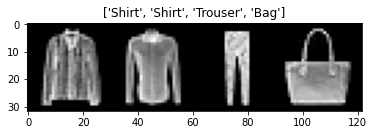

In [ ]:
def imshow(
    input,
    title: str = None,
    ):
    """Imshow for one batch."""
    input = input.numpy().transpose((1, 2, 0))
    plt.imshow(input, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def demo_base(
    dataset_name="FashionMNIST",
    ):
    # No additional data preprocessing or augmentation here  
    demo_tfms = transforms.Compose([
        transforms.ToTensor(),  # This will shift data to [0, 1]
        ])

    if dataset_name == "FashionMNIST":
        demo_dataset = datasets.FashionMNIST(
            root="./data",     # Make sure to have "./" beforehand
            train=True, 
            transform=demo_tfms,    # Leave out transform for now
            download=True,
            )
    else:
        raise Exception("Only one.")

    demo_loader = torch.utils.data.DataLoader(
        demo_dataset, 
        batch_size=4,
        shuffle=True
        )

    # Grab a batch
    inputs, class_indices = next(iter(demo_loader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[demo_dataset.classes[idx] for idx in class_indices])
    
demo_base("FashionMNIST")

## 1.2 Preprocessing



In [ ]:
class CustomNormalize(object):
    def __init__(self, mean, std):
        """A custom normalization object to be used with torchvision.transforms.
        """
        self.mean = mean
        self.std = std

    def __call__(self, x):
        """Given a tensor x of shape (n_channels, height, width), 
        normalize the tensor by the specified mean and std.
        """

        new_x = (x - self.mean) / self.std

        return new_x

mean = 0.5
std = 0.5
preprocessing_tfm = CustomNormalize(mean, std)
# ####################

torch.Size([4, 1, 28, 28])
tensor(1.) tensor(-1.)


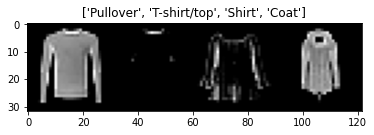

In [ ]:
def demo_preprocessing(
    dataset_name="FashionMNIST",
    ):
    demo_tfms = transforms.Compose([
        transforms.ToTensor(),  # This will shift data to [0, 1]
        preprocessing_tfm,
    ])

    if dataset_name == "FashionMNIST":
        demo_dataset = datasets.FashionMNIST(
            root="./data",     # Make sure to have "./" beforehand
            train=True, 
            transform=demo_tfms,   
            download=True,
            )
    else:
        raise Exception("Only one.")

    demo_loader = torch.utils.data.DataLoader(
        demo_dataset, 
        batch_size=4,
        shuffle=True
        )

    # Grab a batch
    inputs, class_indices = next(iter(demo_loader))

    # Always check your tensor shape
    print(inputs.shape)

    # NOTE: Pass this unittest
    print(inputs.reshape(-1).max(), inputs.reshape(-1).min())
    assert inputs.reshape(-1).max() == 1.0
    assert inputs.reshape(-1).min() == -1.0

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[demo_dataset.classes[idx] for idx in class_indices])

demo_preprocessing("FashionMNIST")

In [ ]:
augmentations = [torchvision.transforms.RandomResizedCrop(135), torchvision.transforms.CenterCrop(236)]

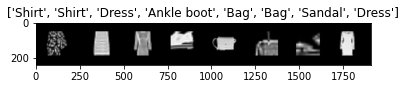

In [ ]:
def demo_augmentation(
    dataset_name="FashionMNIST",
    ):
    demo_tfms = transforms.Compose((
        [] +
        augmentations +
        [transforms.ToTensor()]  # This will shift data to [0, 1]
    ))

    if dataset_name == "FashionMNIST":
        demo_dataset = datasets.FashionMNIST(
            root="./data",     # Make sure to have "./" beforehand
            train=True, 
            transform=demo_tfms,   
            download=True,
            )
    else:
        raise Exception("Only one.")

    demo_loader = torch.utils.data.DataLoader(
        demo_dataset, 
        batch_size=8,
        shuffle=True
        )

    # Grab a batch
    inputs, class_indices = next(iter(demo_loader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[demo_dataset.classes[idx] for idx in class_indices])

# NOTE: Check your images and inspect some of the transformed images
demo_augmentation("FashionMNIST")

## 1.4 Define Dataset


In [ ]:

# augmentations_train_tfms = [torchvision.transforms.RandomResizedCrop(230), 
                            # torchvision.transforms.CenterCrop(236),
                            # torchvision.transforms.CenterCrop(10),
                            # torchvision.transforms.RandomHorizontalFlip()]
augmentations_train_tfms = [torchvision.transforms.RandomHorizontalFlip(),
                            torchvision.transforms.RandomVerticalFlip(),
                            torchvision.transforms.RandomGrayscale(p=0.1)]
train_tfms = transforms.Compose([] +
                               augmentations_train_tfms +
                               [transforms.ToTensor(),
                               preprocessing_tfm])
test_tfms = transforms.Compose([] +
                               [transforms.ToTensor(),
                               preprocessing_tfm])



train_dataset_full = datasets.FashionMNIST(
    root="./data",    
    train=True, 
    transform=train_tfms,
    download=True,
    )

test_dataset = datasets.FashionMNIST(
    root="./data",     
    train=False, 
    transform=test_tfms,
    download=True,
    )

print("Num. train (total, unused):", len(train_dataset_full))
print("Num. test:", len(test_dataset))


maps = {i: [] for i in range(10)}
for idx, (_, cls_idx) in enumerate(train_dataset_full):
    if len(maps[cls_idx]) < 500:
        maps[cls_idx].append(idx)

indices = []
for _, ind in maps.items():
    indices += ind

train_dataset = torch.utils.data.Subset(train_dataset_full, indices)
print("Num. train:", len(train_dataset))



Num. train (total, unused): 60000
Num. test: 10000
Num. train: 5000


# Model & Training



In [ ]:
class MiniVGG(nn.Module):
    def __init__(
        self,
        ):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256 * 3 * 3, 10)
        nn.init.normal_(self.classifier.weight, 0, 0.01)
        nn.init.constant_(self.classifier.bias, 0)

    def forward(
        self, 
        x,
        ):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
class One_Hot(nn.Module):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        self.ones = torch.sparse.torch.eye(depth)
    def forward(self, X_in):
        X_in = X_in.long()
        return self.ones.index_select(0,X_in.data)
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

In [ ]:

batch_size = 256
validate_every = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr = 1e-4

def train(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    test_loader,
    epochs,
    ):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_runtime = None


    epoch_loss_test = 0.0
    epoch_acc = 0.0
    infos = {"train":{'loss':[],'acc':[],'epoch':[]}, "test":{'loss':[],'acc':[],'epoch':[]}}


    # Train loop
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        model.train()
        running_corrects = 0
        epoch_loss_train = 0.0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistics
            _, preds = torch.max(outputs, 1)
            epoch_loss_train += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train /= len(train_loader.dataset)
        epoch_acc_train = running_corrects.double() / len(train_loader.dataset)

        print("Epoch: {} Train loss: {:.4f}, Train Acc {:.4f}".format(epoch + 1, epoch_loss_train, epoch_acc_train))

        if (epoch + 1) % validate_every == 0:
            epoch_acc, runtime, epoch_loss_test = test(model, test_loader)

            # deep copy the best model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_runtime = runtime
            print("Test Acc: {:.4f}".format(epoch_acc))
        print()


        if type(epoch_loss_train)!= float:  
          infos['train']['loss'].append(epoch_loss_train.cpu().numpy().tolist())
        else:
           infos['train']['loss'].append(epoch_loss_train)
        if type(epoch_acc_train)!= float:  
          infos['train']['acc'].append(epoch_acc_train.cpu().numpy().tolist())
        else:
          infos['train']['acc'].append(epoch_acc_train)
        infos['train']['epoch'].append( epoch + 1)
        if type(epoch_loss_test)!= float: 
          infos['test']['loss'].append(epoch_loss_test.cpu().numpy().tolist())
        else:
          infos['test']['loss'].append(epoch_loss_test)
        if type(epoch_acc)!= float: 
          infos['test']['acc'].append(epoch_acc.cpu().numpy().tolist())
        else:
          infos['test']['acc'].append(epoch_acc)
        infos['test']['epoch'].append(epoch + 1)
        # ####################


    print()
    print("Best Acc: {:.4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc, best_runtime, infos


def test(
    model, 
    test_loader, 
    ):
    start = time.time()

    size = len(test_loader.dataset)
    corrects = 0
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for inputs, gts in test_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()

            # Forward only
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu()
            corrects += torch.sum(preds == gts.data)

            CE = nn.CrossEntropyLoss().to(device)
            loss = CE(outputs.to(device), gts.to(device))
            epoch_loss += loss.item()  * inputs.size(0)
        epoch_loss /= len(test_loader.dataset)


    acc = corrects / size
    runtime = time.time() - start
    print("Test Acc: {:.4f}, Runtime: {:.2f}".format(acc, runtime))
    
    return acc, runtime, epoch_loss

We will make use of a pretrained model on Cifar10 to perform transfer learning. A pretrained weight for the above is provided in eClass. 

In order to keep useful information from a pre-trained model, while transferring to the FashionMNIST dataset, we need to freeze all parts of the network except the final classifier layer, so that the gradients are only computed in backward() for the final layer.

### TODO (1.5 out of 5): Complete the coding section in main().

In [ ]:
def main(
    finetune=None,
    epochs=3,
    ):
    # Define your model
    model = MiniVGG()
    # torch.cuda.empty_cache()
    if finetune is not None:

        
        model.load_state_dict(torch.load('/content/drive/MyDrive/5 year/cmput328/assign/6/6'+ finetune[1:], map_location=torch.device('cpu')))

        for name, param in model.named_parameters():
          if 'features' in name:
            # print(name)
            param.requires_grad = False
        model.classifier = torch.nn.Linear(in_features=2304,out_features=10)
        nn.init.normal_(model.classifier.weight, 0, 0.01)
        nn.init.constant_(model.classifier.bias, 0)

        optimizer = optim.Adam(model.parameters(),lr=lr)

    else:
        
        
        model.classifier = torch.nn.Linear(in_features=2304,out_features=10)
        nn.init.normal_(model.classifier.weight, 0, 0.01)
        nn.init.constant_(model.classifier.bias, 0)
        optimizer = optim.Adam(
            model.parameters(),
            lr=lr)

    if torch.cuda.is_available():   # Put to GPU
        model = model.cuda()

    # Loss
    criterion = nn.CrossEntropyLoss()

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        )
    
    best_model, best_acc, best_runtime, train_infos = train(model, criterion, optimizer, train_loader, test_loader, epochs)

    return best_acc, train_infos

In [ ]:
# def init_weights(m):
#     if type(m) == nn.Linear:
#         torch.nn.init.normal_(m.weight, 0.0, 0.01)
#         m.bias.data.fill_(0.01)

In [ ]:
num_runs = 10   

avg_best_acc_finetune_cifar10 = 0.0
for _ in range(num_runs):
    avg_best_acc_finetune_cifar10 += main(finetune="./cifar10_mini_vgg.pth", epochs=3)[0]
avg_best_acc_finetune_cifar10 /= num_runs

avg_best_acc_finetune_mnist = 0.0
for _ in range(num_runs):
    avg_best_acc_finetune_mnist += main(finetune="./mnist_mini_vgg.pth", epochs=3)[0]
avg_best_acc_finetune_mnist /= num_runs
    
avg_best_acc_scratch = 0.0
for _ in range(num_runs):
    avg_best_acc_scratch += main(finetune=None, epochs=3)[0]
avg_best_acc_scratch /= num_runs

Epoch 1/3
----------
Epoch: 1 Train loss: 2.0712, Train Acc 0.2702

Epoch 2/3
----------
Epoch: 2 Train loss: 1.4021, Train Acc 0.5810

Epoch 3/3
----------
Epoch: 3 Train loss: 1.0673, Train Acc 0.6886
Test Acc: 0.7188, Runtime: 1.41
Test Acc: 0.7188


Best Acc: 0.7188
Epoch 1/3
----------
Epoch: 1 Train loss: 2.2570, Train Acc 0.2130

Epoch 2/3
----------
Epoch: 2 Train loss: 1.5561, Train Acc 0.4834

Epoch 3/3
----------
Epoch: 3 Train loss: 1.1720, Train Acc 0.6454
Test Acc: 0.6635, Runtime: 1.43
Test Acc: 0.6635


Best Acc: 0.6635
Epoch 1/3
----------
Epoch: 1 Train loss: 2.2139, Train Acc 0.2234

Epoch 2/3
----------
Epoch: 2 Train loss: 1.5172, Train Acc 0.5136

Epoch 3/3
----------
Epoch: 3 Train loss: 1.1578, Train Acc 0.6624
Test Acc: 0.6889, Runtime: 1.39
Test Acc: 0.6889


Best Acc: 0.6889
Epoch 1/3
----------
Epoch: 1 Train loss: 2.0418, Train Acc 0.2644

Epoch 2/3
----------
Epoch: 2 Train loss: 1.4194, Train Acc 0.5586

Epoch 3/3
----------
Epoch: 3 Train loss: 1.1060, T

In [ ]:
print("Average accuracy w/ Finetuning (Cifar10):", avg_best_acc_finetune_cifar10)
print("Average accuracy w/ Finetuning (MNIST):", avg_best_acc_finetune_mnist)
print("Average accuracy w/o Finetuning:", avg_best_acc_scratch)

Epoch 1/50
----------
Epoch: 1 Train loss: 2.1257, Train Acc 0.2390

Epoch 2/50
----------
Epoch: 2 Train loss: 1.4737, Train Acc 0.5162

Epoch 3/50
----------
Epoch: 3 Train loss: 1.1118, Train Acc 0.6716
Test Acc: 0.6836, Runtime: 1.36
Test Acc: 0.6836

Epoch 4/50
----------
Epoch: 4 Train loss: 0.9295, Train Acc 0.7300

Epoch 5/50
----------
Epoch: 5 Train loss: 0.8136, Train Acc 0.7562

Epoch 6/50
----------
Epoch: 6 Train loss: 0.7369, Train Acc 0.7774
Test Acc: 0.7670, Runtime: 1.39
Test Acc: 0.7670

Epoch 7/50
----------
Epoch: 7 Train loss: 0.6813, Train Acc 0.7914

Epoch 8/50
----------
Epoch: 8 Train loss: 0.6422, Train Acc 0.7988

Epoch 9/50
----------
Epoch: 9 Train loss: 0.6050, Train Acc 0.8094
Test Acc: 0.8008, Runtime: 1.39
Test Acc: 0.8008

Epoch 10/50
----------
Epoch: 10 Train loss: 0.5784, Train Acc 0.8180

Epoch 11/50
----------
Epoch: 11 Train loss: 0.5589, Train Acc 0.8180

Epoch 12/50
----------
Epoch: 12 Train loss: 0.5324, Train Acc 0.8296
Test Acc: 0.8157, Ru

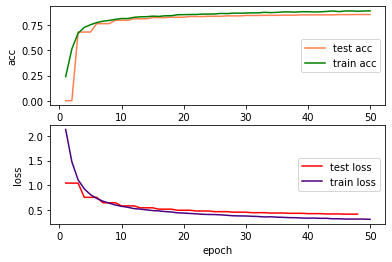

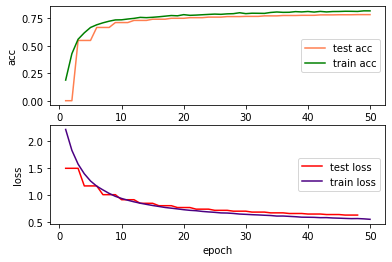

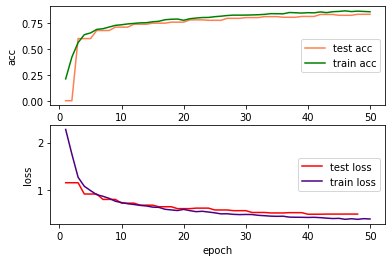

In [ ]:
def visualize_train_infos(train_infos):
    """Visualize and plot training infos.
    """

    fig, ax = plt.subplots(2) # make two plots
    ax[0].plot(train_infos['test']['epoch'],train_infos['test']['acc'], color="coral",label="test acc")
    ax[0].plot(train_infos['train']['epoch'],train_infos['train']['acc'], color="green",label="train acc")
    leg = ax[0].legend(loc='center right')

    ax.flat[0].set(xlabel='epoch', ylabel='acc') #lable 1
    ax[1].plot(train_infos['test']['epoch'][:48],train_infos['test']['loss'][2:], color="red",label="test loss")
    ax[1].plot(train_infos['train']['epoch'],train_infos['train']['loss'], color="Indigo",label="train loss")
    leg = ax[1].legend(loc='center right')
    ax.flat[1].set(xlabel='epoch', ylabel='loss')#lable 1
    plt.show();

    return 

epochs = 50

_, train_infos_cifar10_mini_vgg = main(finetune="./cifar10_mini_vgg.pth", epochs=epochs)

_, train_infos_mnist_mini_vgg = main(finetune="./mnist_mini_vgg.pth", epochs=epochs)

_, train_infos_scratch_mini_vgg = main(finetune=None, epochs=epochs)

visualize_train_infos(train_infos_cifar10_mini_vgg)
visualize_train_infos(train_infos_mnist_mini_vgg)
visualize_train_infos(train_infos_scratch_mini_vgg)

## debuging 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50] [2.125692473220825, 1.4736534133911132, 1.1118223143577575, 0.9294736192703247, 0.8136283549308777, 0.7369178315162659, 0.681269862651825, 0.6422045476913452, 0.6050499797821045, 0.5784208869934082, 0.5588888374328613, 0.5323793633460998, 0.5220933462142945, 0.5070839627265931, 0.4923113655090332, 0.4858039008140564, 0.4729657295703888, 0.464741464138031, 0.44733257780075075, 0.44259154353141783, 0.4342189681053162, 0.4279276258468628, 0.41818614225387574, 0.4140657939910889, 0.4122591012477875, 0.4064706964969635, 0.3972803640842438, 0.3876736524581909, 0.38506574950218203, 0.3836567723274231, 0.3778545045375824, 0.37315894122123716, 0.3644808828830719, 0.36806989011764524, 0.3603631368637085, 0.3562493215560913, 0.35060888867378237, 0.34903188734054563, 0.34291429419517516, 0.3399729629993439, 0

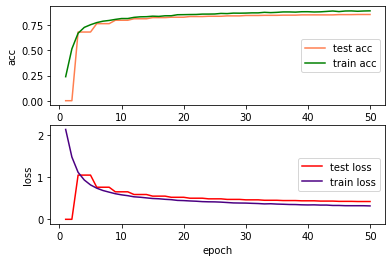

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
train_infos = train_infos_cifar10_mini_vgg
print(train_infos['train']['epoch'],train_infos['train']['loss'])
print(train_infos['train']['epoch'],train_infos['train']['acc'])
print(train_infos['test']['epoch'],train_infos['test']['loss'])
print(train_infos['test']['epoch'],train_infos['test']['acc'])

fig, ax = plt.subplots(2) # make two plots
ax[0].plot(train_infos['test']['epoch'],train_infos['test']['acc'], color="coral",label="test acc")
ax[0].plot(train_infos['train']['epoch'],train_infos['train']['acc'], color="green",label="train acc")
leg = ax[0].legend(loc='center right')

ax.flat[0].set(xlabel='epoch', ylabel='acc') #lable 1
ax[1].plot(train_infos['test']['epoch'],train_infos['test']['loss'], color="red",label="test loss")
ax[1].plot(train_infos['train']['epoch'],train_infos['train']['loss'], color="Indigo",label="train loss")
leg = ax[1].legend(loc='center right')
ax.flat[1].set(xlabel='epoch', ylabel='loss')#lable 1
plt.show();